In [1]:
from fmri.acquisitions import SparklingAcquisition
from fmri.reconstructors.base import SequentialFMRIReconstructor
from mri.operators import WaveletN 
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt
from fmri.utils import ssos

In [2]:
data_file = "/volatile/pierre-antoine/optimed/meas_MID36_2D_Sparkling_1mmiso0_3s_FID3362.dat"
bin_file = "/volatile/pierre-antoine/optimed/dim2_i_RadialIO_P0.75_N192x192_FOV0.192x0.192_Nc6_Ns2688_c30_d2__D7M9Y2021T160.bin"
shifts = np.array((-22,0))


In [3]:
acq = SparklingAcquisition(data_file,bin_file,
                           frame_slicer=slice(0,100),
                           shifts=shifts,
                           )
acq

pymapVBVD version 0.4.3
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/15.4G [00:00<?, ?B/s]

read data:   0%|          | 0/600 [00:00<?, ?it/s]

/home/pc266769/.pyenv/versions/3.6.13/envs/fmri/lib/python3.6/site-packages/mri/operators/fourier/utils.py:106: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")


SparklingAcquisition(
shots=6
samples/shots=2688
coils=32
timeframes=100
img_dim=2
img_shape=[192 192]
FOV=[0.192 0.192]
Oversampling=5
)

In [4]:
acq.kspace_data.shape, acq.kspace_loc.shape,

((100, 32, 80640), (80640, 2))

In [5]:
fourier_op = acq.get_fourier_operator(implementation='gpuNUFFT')
fourier_op.shape, fourier_op.samples, fourier_op.n_coils
mu=1e-8
regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")

linear_op = WaveletN(wavelet_name='sym8',
                    nb_scale=3,
                    dim=2,)


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:    0.2s remaining:    2.5s
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:    0.4s finished


(32, 192, 192)


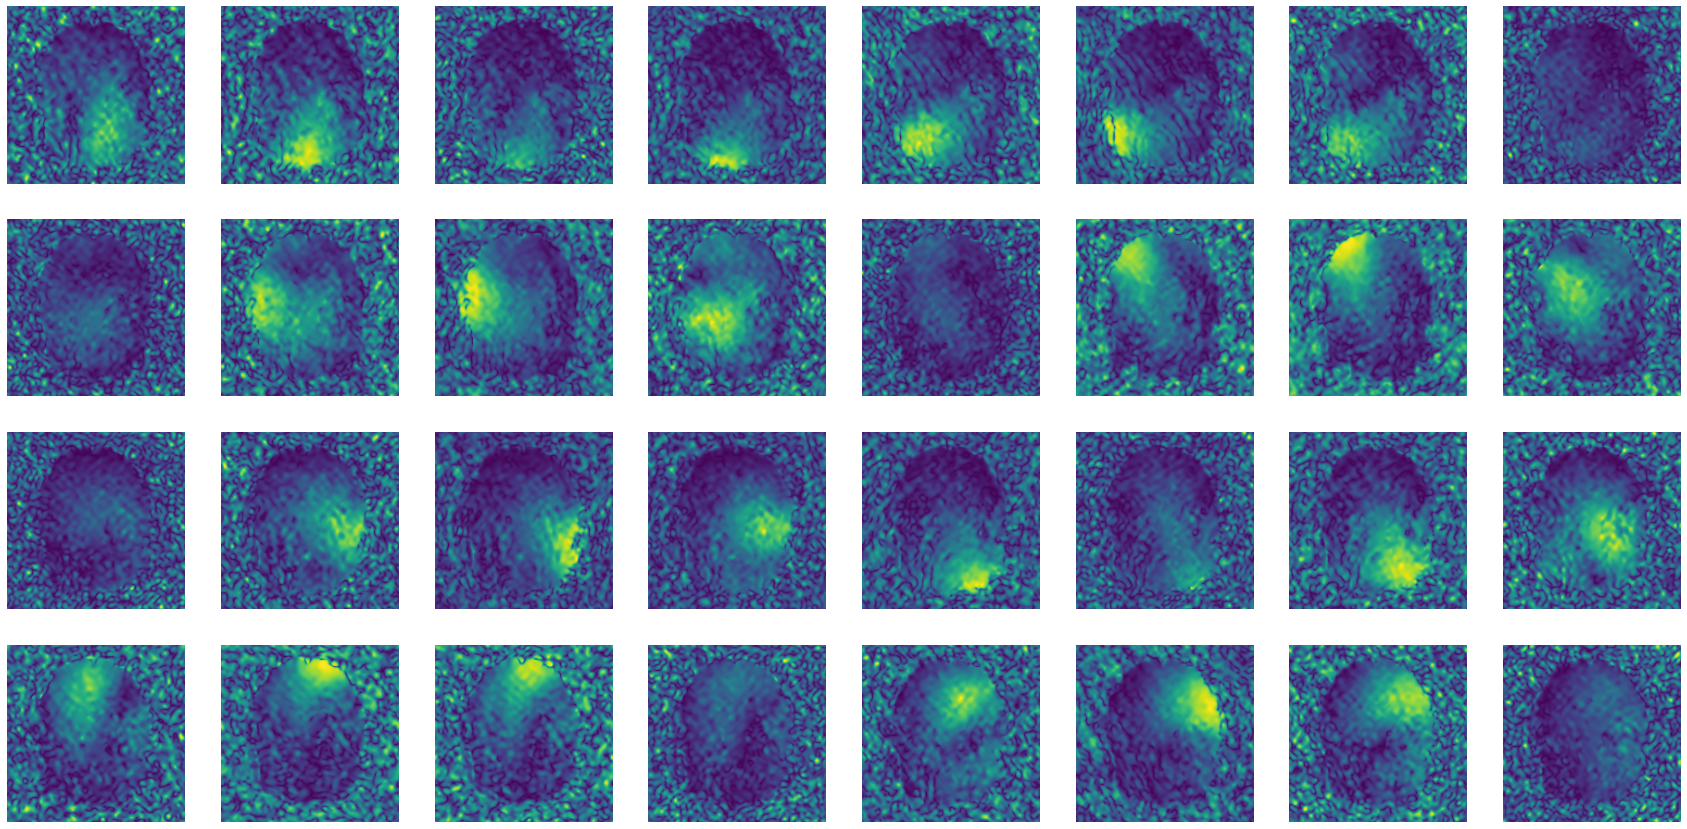

NFFT
(32, 192, 192)


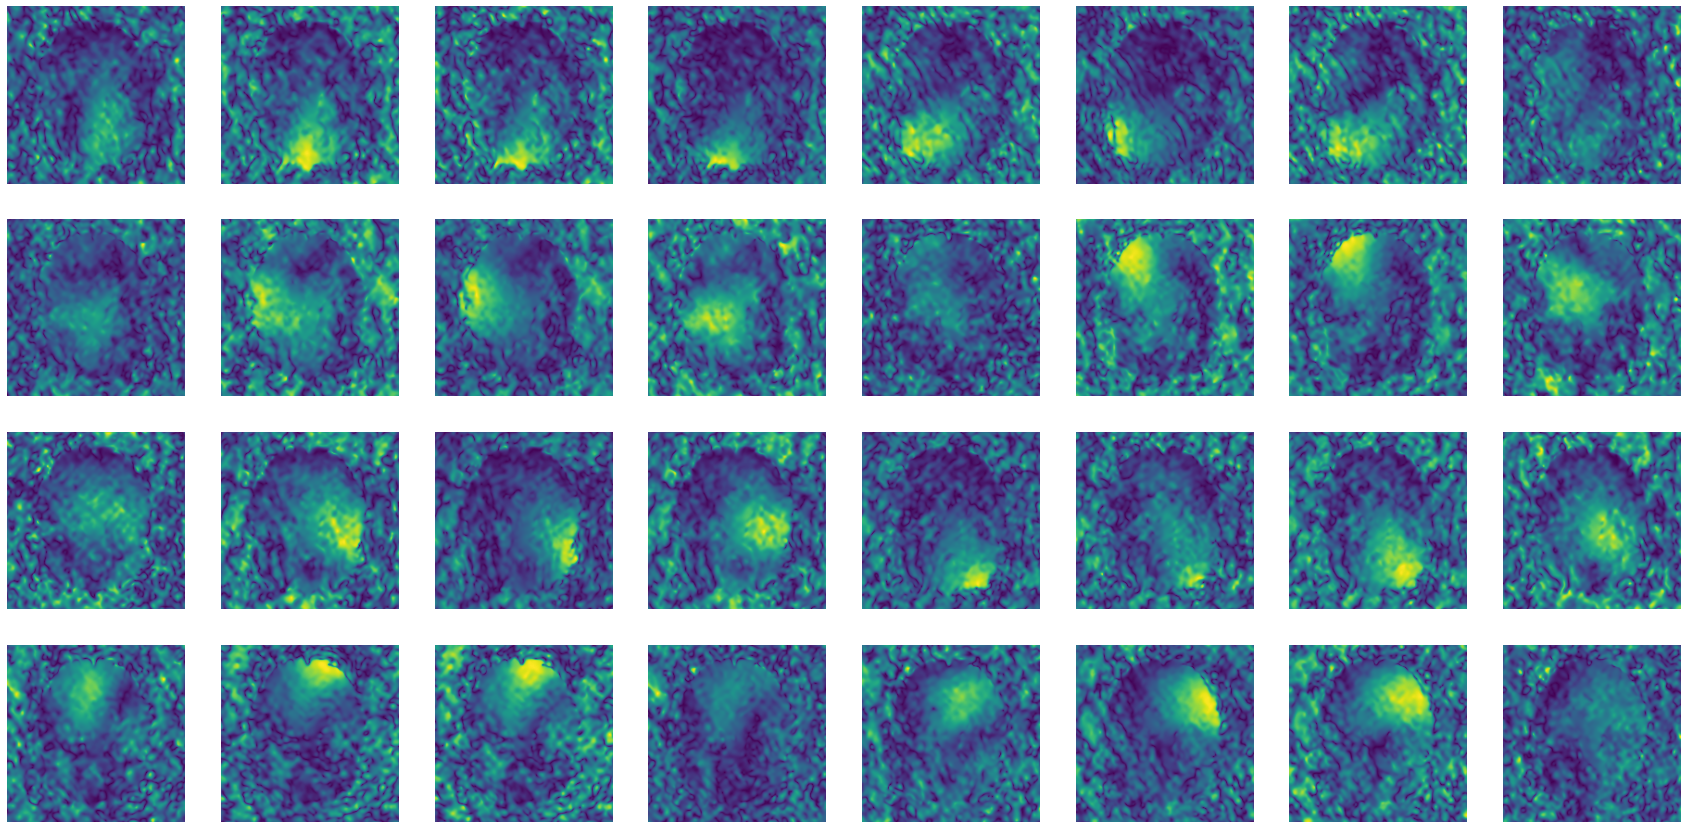

In [27]:
%matplotlib inline
smaps = acq.get_smaps(mode='gridding',density_comp=acq.density_comp,thresh=0.1)
plt.rcParams['figure.figsize'] = [30, 15]
print(smaps.shape)
fig, ax = plt.subplots(4,8)
for i in range(len(smaps)):
    ax.flatten()[i].imshow(abs(smaps[i,...]))
    ax.flatten()[i].axis('off')

plt.show()
# plt.figure()
# plt.imshow(ssos(smaps))
# plt.show()

print("NFFT",flush=True)
smaps = acq.get_smaps(mode='NFFT',density_comp=acq.density_comp,thresh=0.1)


plt.rcParams['figure.figsize'] = [30, 15]
print(smaps.shape)
fig, ax = plt.subplots(4,8)
for i in range(len(smaps)):
    ax.flatten()[i].imshow(abs(smaps[i,...]))
    ax.flatten()[i].axis('off')




In [7]:
rec = SequentialFMRIReconstructor(fourier_op, linear_op, regularizer_op, Smaps=smaps, verbose=50, optimizer='pogm')

/volatile/pierre-antoine/gits/nsp/pysap-fmri/fmri/reconstructors/base.py:36: UserWarning: The in-time regularizer is not set. Setting to identity. Note that frame will be reconstruct independently.
  warnings.warn("The in-time regularizer is not set. Setting to identity. "


Lipschitz constant is 0.15528988682927267
The lipschitz constraint is satisfied


In [8]:
res = rec.reconstruct(acq.kspace_data)

100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (15 of 15) |#######################

In [9]:
from IPython import display
import matplotlib.pyplot as plt
import time

In [10]:
%matplotlib inline
def dynamic_img(fmri_img, fps:float=2, normalize=True):
    """ dynamic plot of fmri data"""

    fmri_img = np.abs(fmri_img)
    if normalize:
        fmri_img *= (255.0/fmri_img.max())

    fig,ax = plt.subplots()
    obj_show = ax.imshow(np.zeros_like(fmri_img[0,:]))
    for img in fmri_img:
        obj_show.set_data(img)
        time.sleep(1./fps)
        plt.draw()

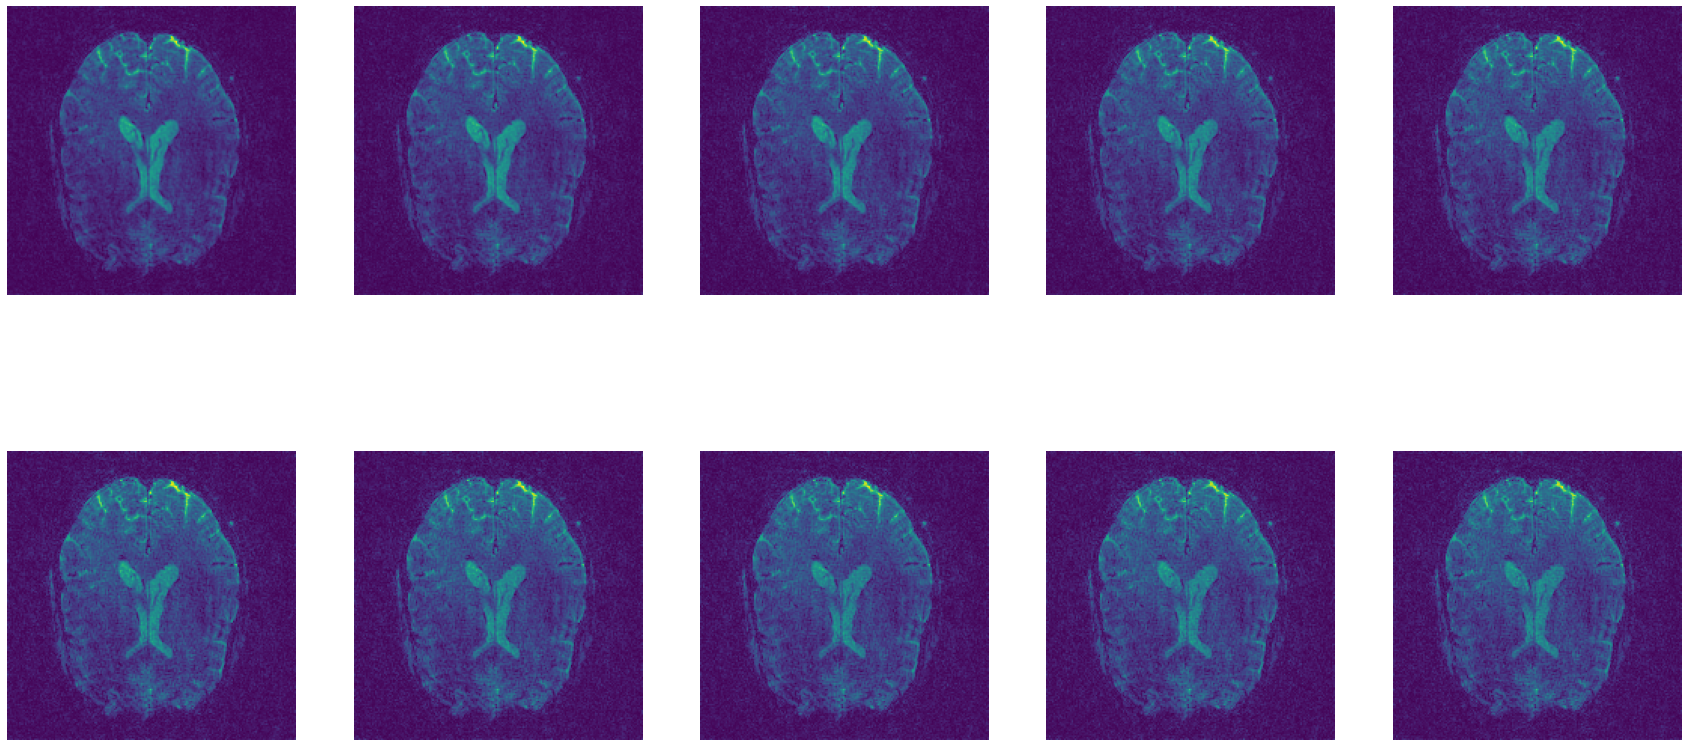

In [28]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, axs = plt.subplots(2,5)
for img,ax in zip(res,axs.flatten()):
    ax.imshow(abs(img))
    ax.axis('off')
plt.show()

In [13]:
%matplotlib notebook
import matplotlib.animation as anim
fig = plt.figure()
plt.axis("off")
ims = [ [plt.imshow(abs(res[i,...]),animated=True)] for i in range(len(res))]

ani = anim.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat_delay=1000)

ani.save('rs-fmri.mp4')

<IPython.core.display.Javascript object>